In [26]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Required Libraries
import os
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support, classification_report
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
import pickle
import mlflow
import mlflow.sklearn
import seaborn as sns

In [19]:
# Download NLTK resources if not already available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing Utilities
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\misty.hickman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\misty.hickman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\misty.hickman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def preprocess_text(text):
    """Preprocess text: tokenization, lemmatization, and stopword removal."""
    if not isinstance(text, str):
        return ""
    tokens = nltk.word_tokenize(text.lower())
    lemmatized_tokens = [
        lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words
    ]
    return " ".join(lemmatized_tokens)

In [5]:
# Paths and Directories
today = datetime.today().strftime("%Y-%m-%d")
run_dir = f"C:/Users/misty.hickman/OneDrive/Documents/dev_work/TopicModeling/model_artifacts/run_{today}"
visualizations_dir = f"{run_dir}/visualizations"
os.makedirs(run_dir, exist_ok=True)
os.makedirs(visualizations_dir, exist_ok=True)

In [6]:
# Load the data
data_path = "research_review_data.csv"
df = pd.read_csv(data_path)

In [7]:
# Preprocess Text Columns
df['processed_reviews'] = df['reviews'].apply(preprocess_text)
df['processed_response_reviews'] = df['response_reviews'].apply(preprocess_text)
df['combined_text'] = df['processed_reviews'] + " " + df['processed_response_reviews']

In [20]:
# Calculate Duration Time
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['duration_time'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 3600  # Hours


In [21]:
# Prepare Data for LDA
texts = df['combined_text'].str.split()
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [10]:
df.head()

,reviews,response_reviews,start_date,end_date,processed_reviews,processed_response_reviews,combined_text,duration_time
0,The focus is on presenting a balanced perspect...,Focus on connecting your findings back to the ...,2024-12-07 10:33:00,2024-12-28 13:33:00,focus presenting balanced perspective addressi...,focus connecting finding back main research qu...,focus presenting balanced perspective addressi...,507.0
1,I began researching the topic of biology by fo...,"Your initial review is detailed, but consider ...",2024-11-04 13:33:00,2024-11-10 22:33:00,began researching topic biology focusing write...,initial review detailed consider expanding key...,began researching topic biology focusing write...,153.0
2,This research aims to provide a comprehensive ...,Ensure your conclusions align with the evidenc...,2024-10-23 08:33:00,2024-11-12 08:33:00,research aim provide comprehensive understandi...,ensure conclusion align evidence presented exc...,research aim provide comprehensive understandi...,480.0
3,Time management was essential for completing t...,Consider narrowing your focus to make the argu...,2024-12-01 00:33:00,2024-12-05 06:33:00,time management essential completing task rela...,consider narrowing focus make argument concise...,time management essential completing task rela...,102.0
4,One challenge was finding sufficient resources...,Excellent use of resources; keep up the thorou...,2024-11-13 06:33:00,2024-11-26 11:33:00,one challenge finding sufficient resource art ...,excellent use resource keep thorough analysis ...,one challenge finding sufficient resource art ...,317.0


In [22]:
# Train LDA Model
num_topics = 10
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)


In [23]:
# Save LDA Artifacts
lda_model.save(os.path.join(run_dir, "lda_model"))
dictionary.save(os.path.join(run_dir, "dictionary.dict"))
with open(os.path.join(run_dir, "corpus.pkl"), "wb") as f:
    pickle.dump(corpus, f)

In [24]:
# Load LDA Model Artifacts
logged_model = LdaModel.load(os.path.join(run_dir, "lda_model"))
logged_dictionary = Dictionary.load(os.path.join(run_dir, "dictionary.dict"))
with open(os.path.join(run_dir, "corpus.pkl"), "rb") as f:
    logged_corpus = pickle.load(f)

In [25]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.95, min_df=2)
X_tfidf = tfidf_vectorizer.fit_transform(df['combined_text'])

In [26]:
# Train Random Forest Regressor
X = X_tfidf
y = df['duration_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
# Evaluate Model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 44794.42726000001


In [37]:
# Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 features
top_features = [tfidf_vectorizer.get_feature_names_out()[i] for i in indices]

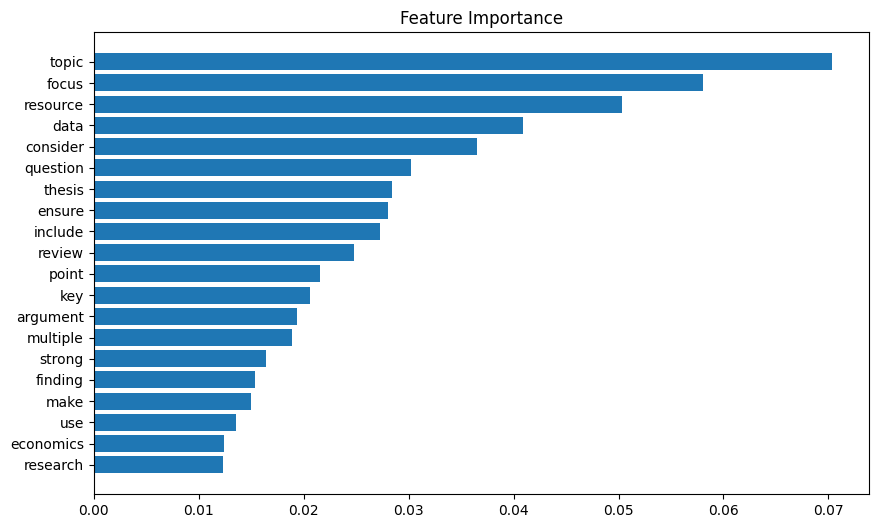

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], importances[indices][::-1])
plt.title("Feature Importance")
plt.savefig(os.path.join(visualizations_dir, "feature_importance.png"))

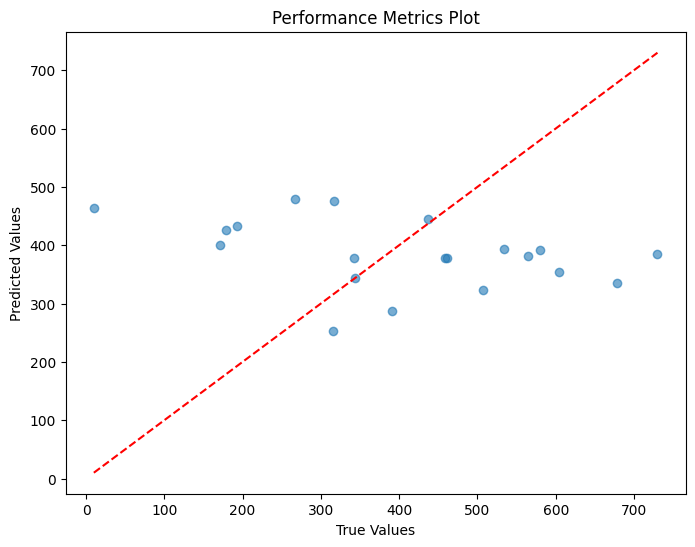

In [39]:
# Performance Metrics Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.title("Performance Metrics Plot")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.savefig(os.path.join(visualizations_dir, "performance_metrics.png"))
plt.show()